In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

In [2]:
print(torch.cuda.is_available())

True


In [3]:
# Проверяем, доступны ли GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
# Загрузка DataFrame из файла
with open(r'./datasets/seg_maps_dataset.pkl', 'rb') as f:
    df = pickle.load(f)

In [5]:
df = df.loc[df['Stats'].isin([1.e+08, 2.e+08, 5.e+08])]

df['Stats'].unique()

array([1.e+08, 2.e+08, 5.e+08])

In [6]:
crystals = np.array(df['Crystal'].unique())

df['Crystal'].unique()

array(['Al', 'Al2O3_sapphire', 'Ba', 'Be', 'BeO', 'C_diamond',
       'C_graphite', 'Cr', 'Cs', 'Cu', 'Cu2MnAl', 'Fe', 'Ga', 'Ge',
       'He4_hcp', 'I2', 'K', 'Mo', 'Na2Ca3Al2F14', 'Nb', 'Ni', 'Pb', 'Pt',
       'Rb', 'Si', 'Ti', 'Tl', 'UO2', 'Zn', 'Y2O3'], dtype=object)

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

X = df.drop(['Crystal', 'Stats', 'Pulce duration'], axis=1)

# Шаг 1: Преобразование строковых меток классов в числовые метки
label_encoder = LabelEncoder()

Stats = df['Stats']

y = df['Crystal']

y_encoded = label_encoder.fit_transform(y)

Diff_train, Diff_test, Stats_train, Stats_test, y_train, y_test = train_test_split(X, Stats, y_encoded, test_size=0.5, random_state=42)

In [8]:
import torch.nn.functional as F

# Преобразование матриц в numpy массив перед преобразованием в тензоры
Diff_train_matrices = np.array(Diff_train['Matrix'].tolist())
Diff_test_matrices = np.array(Diff_test['Matrix'].tolist())

Stats_train_matrices = np.array(Stats_train.tolist())
Stats_test_matrices = np.array(Stats_test.tolist())

# Преобразование данных в тензоры PyTorch
Diff_train_tensor = torch.FloatTensor(Diff_train_matrices)
Diff_train_tensor = Diff_train_tensor.unsqueeze(1)
#Diff_train_tensor = F.interpolate(Diff_train_tensor, size=(256, 480), mode='bicubic', align_corners=False)
Diff_train_tensor = Diff_train_tensor * 2.0 - 1.0
Stats_train_tensor = torch.FloatTensor(Stats_train_matrices)

y_train_tensor = torch.LongTensor(y_train)  # Используем LongTensor для целевых меток

Diff_test_tensor = torch.FloatTensor(Diff_test_matrices)
Diff_test_tensor = Diff_test_tensor.unsqueeze(1)
#Diff_test_tensor = F.interpolate(Diff_test_tensor, size=(256, 480), mode='bicubic', align_corners=False)
Diff_test_tensor = Diff_test_tensor * 2.0 - 1.0
Stats_test_tensor = torch.FloatTensor(Stats_test_matrices)

y_test_tensor = torch.LongTensor(y_test)

In [10]:
print(Diff_train_tensor.size())
print(Diff_test_tensor.size())

torch.Size([900, 1, 250, 480])
torch.Size([900, 1, 250, 480])


In [11]:
from torch.utils.data import TensorDataset, DataLoader, random_split

# Создание набора данных
train_dataset = TensorDataset(Diff_train_tensor, y_train_tensor)

test_dataset = TensorDataset(Diff_test_tensor, y_test_tensor)

# Создание DataLoader для каждой выборки
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)

test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

In [12]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

# Загружаем предобученную ResNet18
model = models.resnet18(pretrained=True)

# Изменяем первый сверточный слой
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Инициализируем веса первого слоя
nn.init.kaiming_normal_(model.conv1.weight, mode='fan_out', nonlinearity='relu')

# Изменяем последний полносвязный слой для вашего количества классов
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(crystals))

C:\Users\neUral\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\neUral\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
model.to(device)

epochs = 10

criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.99))

In [14]:
from tqdm import tqdm

for i in range(epochs):
  
    total_train_loss = 0.0
    total_test_loss = 0.0
    
    model.train()  # Включаем режим обучения

    for x_batch, y_batch in tqdm(train_loader):
        # 1. # загружаем батч данных (вытянутый в линию)
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        # 2. вычисляем скор с помощью прямого распространения ( .forward or .__call__ )
        logits = model(x_batch)

        # 3. вычислеяем - функцию потерь (loss)
        loss = criterion(logits, y_batch)

        # 4. вычисляем градиенты
        optimizer.zero_grad()
        loss.backward()

        # 5. шаг градиентного спуска
        optimizer.step()

        total_train_loss += loss.item()

    model.eval()
    with torch.no_grad():
        for x_batch, y_batch in tqdm(test_loader):
            # 1. # загружаем батч данных (вытянутый в линию)
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            # 2. вычисляем скор с помощью прямого распространения ( .forward or .__call__ )
            logits = model(x_batch)

            # 3. вычислеяем - функцию потерь (loss)
            loss = criterion(logits, y_batch)

            total_test_loss += loss.item()

    print(f'Epoch {i+1}, Loss: {total_train_loss/len(train_loader)}, Loss test: {total_test_loss/len(test_loader)}')

100%|██████████| 90/90 [00:00<00:00, 123.88it/s]


Epoch 1, Loss: 1.3748871331413588, Loss test: 0.4906220727496677


100%|██████████| 90/90 [00:00<00:00, 125.51it/s]


Epoch 2, Loss: 0.15214733593165874, Loss test: 0.3780640901790725


100%|██████████| 90/90 [00:00<00:00, 125.76it/s]


Epoch 3, Loss: 0.04224661089893844, Loss test: 0.022393246227875353


100%|██████████| 90/90 [00:00<00:00, 124.83it/s]


Epoch 4, Loss: 0.01757757274640931, Loss test: 0.013228906600529122


100%|██████████| 90/90 [00:00<00:00, 125.70it/s]


Epoch 5, Loss: 0.014618429070752528, Loss test: 0.15300507379902734


100%|██████████| 90/90 [00:00<00:00, 126.58it/s]


Epoch 6, Loss: 0.046022547791815464, Loss test: 0.016026182430020224


100%|██████████| 90/90 [00:00<00:00, 124.48it/s]


Epoch 7, Loss: 0.008416815616914795, Loss test: 0.02516646565248569


100%|██████████| 90/90 [00:00<00:00, 126.58it/s]


Epoch 8, Loss: 0.003958396133708043, Loss test: 0.007415525219079832


100%|██████████| 90/90 [00:00<00:00, 125.52it/s]


Epoch 9, Loss: 0.002432824006407625, Loss test: 0.0075781325656862466


100%|██████████| 90/90 [00:00<00:00, 124.65it/s]

Epoch 10, Loss: 0.0015997755574062467, Loss test: 0.008331822259626481


Accuracy: 1.00
Precision (Weighted): 1.00
Recall (Weighted): 1.00
F1-Score (Weighted): 1.00


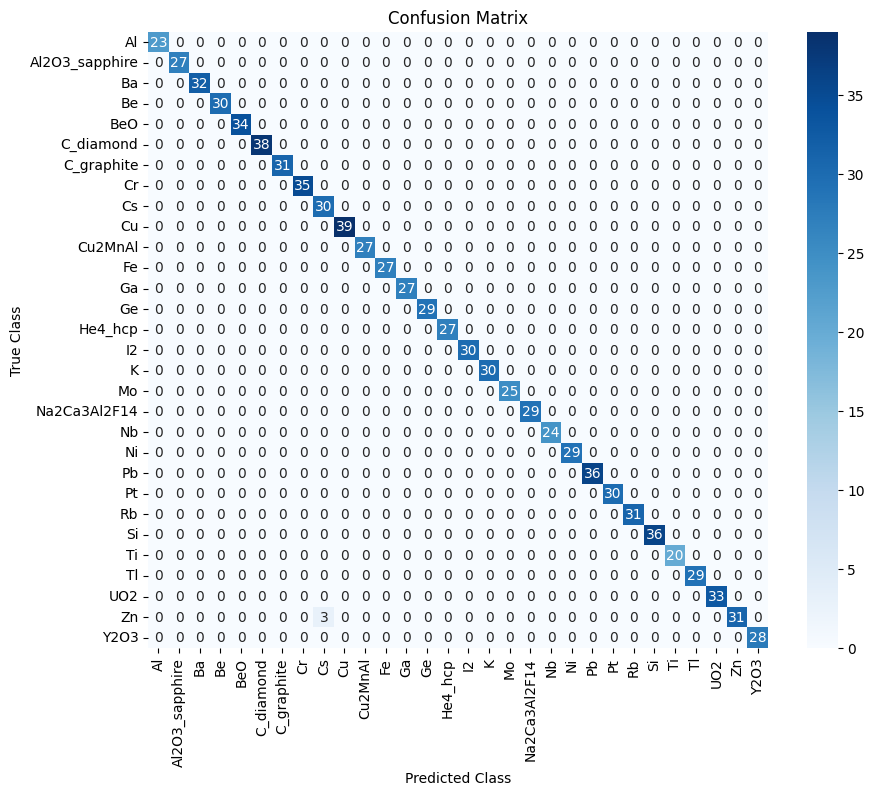

In [15]:
import torch
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# Списки для хранения предсказаний и истинных значений
all_preds = []
all_targets = []

# Отключаем автоматическое вычисление градиентов, так как мы делаем оценку
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        # Добавляем предсказания и целевые значения в списки
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

# Преобразуем списки в numpy-массивы
all_preds = np.array(all_preds)
all_targets = np.array(all_targets)

# Вычисляем метрики на всем датасете
accuracy = accuracy_score(all_targets, all_preds)
precision = precision_score(all_targets, all_preds, average='weighted')
recall = recall_score(all_targets, all_preds, average='weighted')
f1 = f1_score(all_targets, all_preds, average='weighted')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision (Weighted): {precision:.2f}")
print(f"Recall (Weighted): {recall:.2f}")
print(f"F1-Score (Weighted): {f1:.2f}")

# Построение и визуализация матрицы ошибок
conf_matrix = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=crystals, yticklabels=crystals)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix")
plt.show()

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

def bootstrap_metrics(
    y_true,
    y_pred,
    n_bootstrap=1000,
    alpha=0.95,
    average='weighted',
    random_state=42
):
    rng = np.random.default_rng(random_state)
    n = len(y_true)

    accs, precs, recs, f1s = [], [], [], []

    for _ in range(n_bootstrap):
        indices = rng.integers(0, n, size=n)

        y_true_bs = y_true[indices]
        y_pred_bs = y_pred[indices]

        accs.append(accuracy_score(y_true_bs, y_pred_bs))
        precs.append(precision_score(y_true_bs, y_pred_bs, average=average, zero_division=0))
        recs.append(recall_score(y_true_bs, y_pred_bs, average=average, zero_division=0))
        f1s.append(f1_score(y_true_bs, y_pred_bs, average=average, zero_division=0))

    def ci(x):
        lower = np.percentile(x, (1 - alpha) / 2 * 100)
        upper = np.percentile(x, (1 + alpha) / 2 * 100)
        return np.mean(x), lower, upper

    return {
        "accuracy": ci(accs),
        "precision": ci(precs),
        "recall": ci(recs),
        "f1": ci(f1s),
    }

bootstrap_results = bootstrap_metrics(
    all_targets,
    all_preds,
    n_bootstrap=1000,   # можно 1000–10000
    alpha=0.95,
    average='weighted'
)

for metric, (mean, low, high) in bootstrap_results.items():
    print(
        f"{metric.capitalize():10s}: "
        f"{mean:.3f} "
        f"[{low:.3f}, {high:.3f}] (95% CI)"
    )


Accuracy  : 1.000 [1.000, 1.000] (95% CI)
Precision : 1.000 [1.000, 1.000] (95% CI)
Recall    : 1.000 [1.000, 1.000] (95% CI)
F1        : 1.000 [1.000, 1.000] (95% CI)


In [17]:
# допустим, твоя текущая модель называется vae
save_path = "models/ResNet_18_classifier_diffractions.pth"
torch.save(model.state_dict(), save_path)
print(f"✅ Модель сохранена в {save_path}")

✅ Модель сохранена в models/ResNet_18_classifier_diffractions.pth


Извлечение признаков: 100%|██████████| 90/90 [00:01<00:00, 86.12it/s] 
c:\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Не удается найти указанный файл
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(


Всего образцов: 900
Размерность признаков: (900, 512)
Размерность изображений: (900, 120000)
Выполняем t-SNE на исходных изображениях...


  File "c:\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Python312\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python312\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Python312\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^



Выполняем t-SNE на признаках модели...


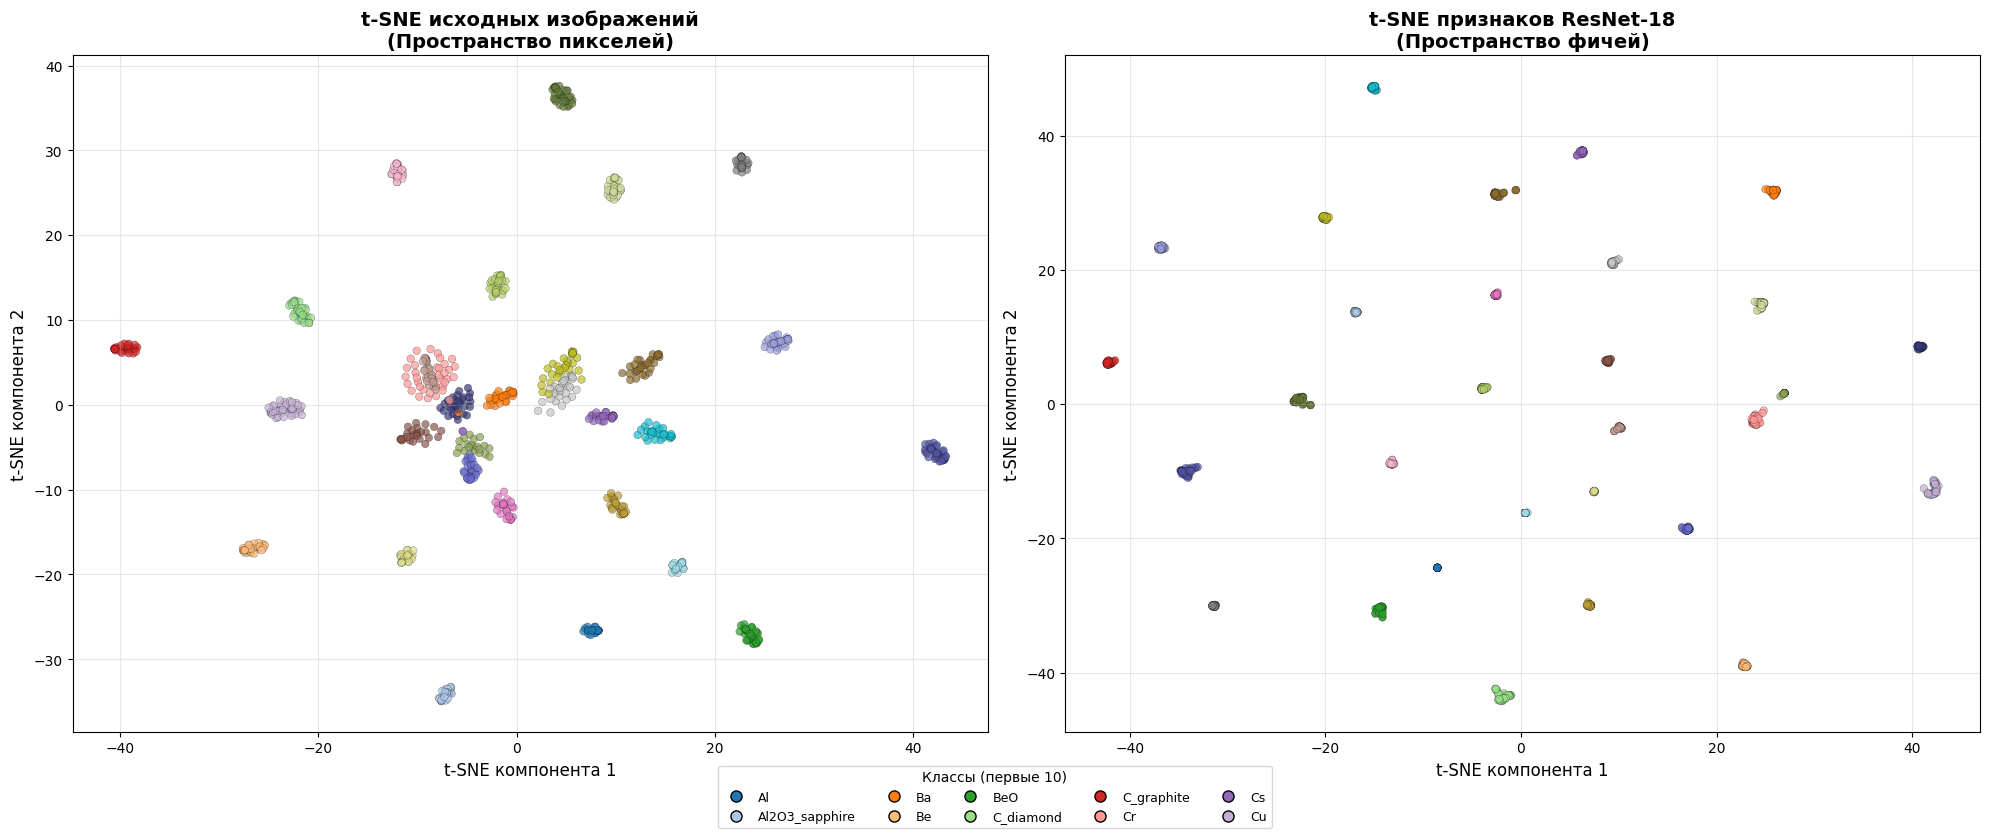


СТАТИСТИКА КЛАССОВ:
Al: 23 образцов
Al2O3_sapphire: 27 образцов
Ba: 32 образцов
Be: 30 образцов
BeO: 34 образцов
C_diamond: 38 образцов
C_graphite: 31 образцов
Cr: 35 образцов
Cs: 30 образцов
Cu: 39 образцов
Всего уникальных классов: 30


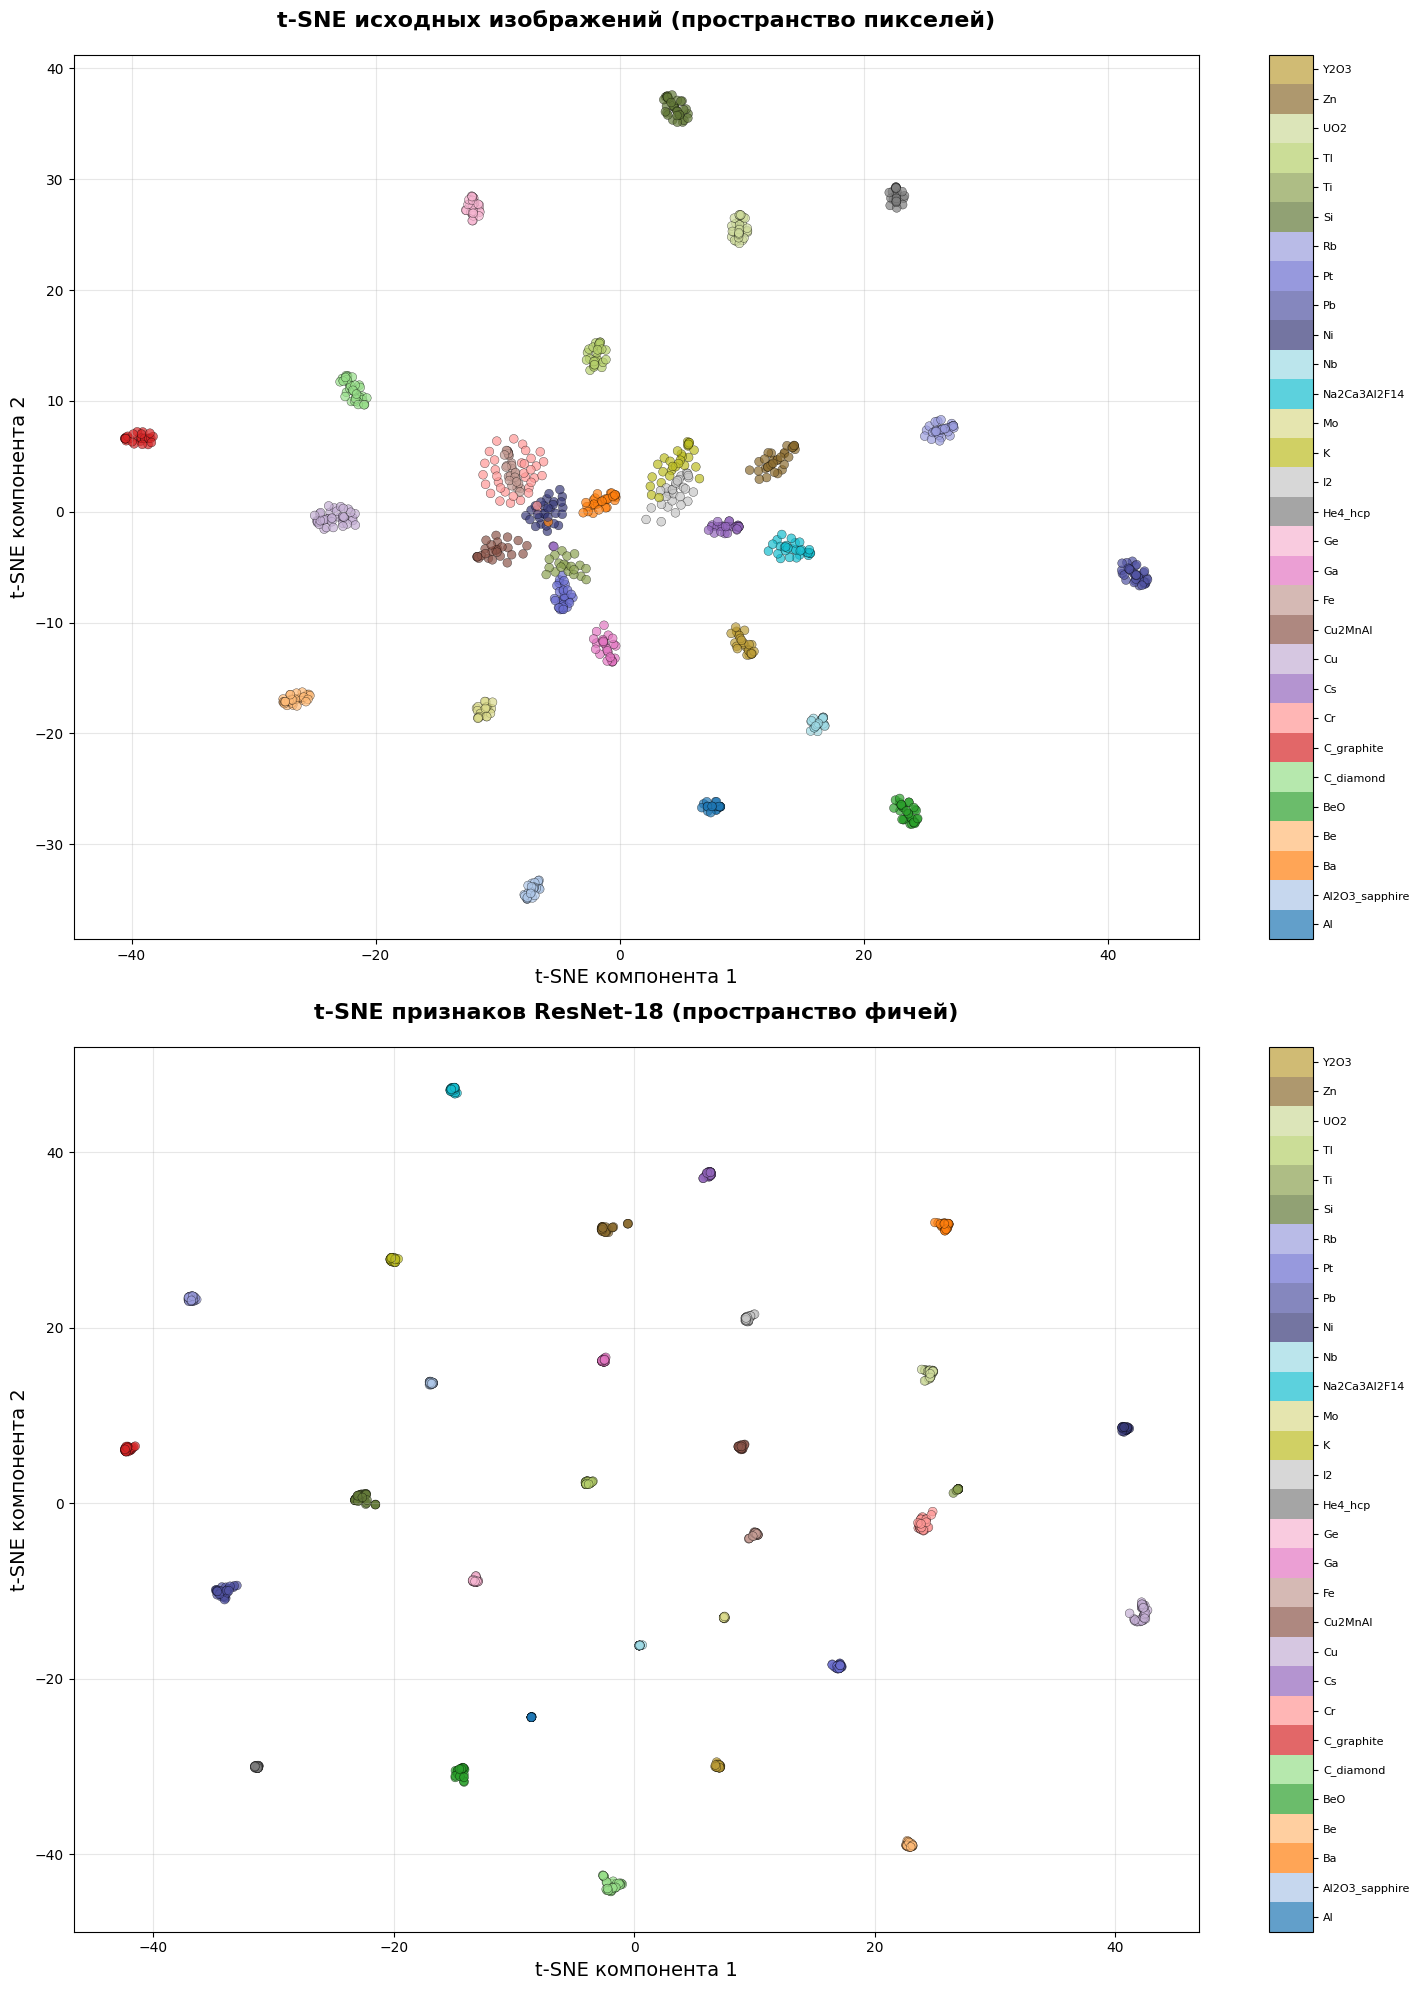

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import torch
from tqdm import tqdm
import seaborn as sns

# Ваш FeatureExtractor (как вы процитировали)
class FeatureExtractor(nn.Module):
    def __init__(self, classifier):
        super().__init__()
        self.features = nn.Sequential(*list(classifier.children())[:-1])  # До fc-слоя
    
    def forward(self, x):
        x = self.features(x)
        return x.view(x.size(0), -1)  # [B, 512]

# Предполагаем, что classifier, model, device, train_loader определены
extractor = FeatureExtractor(model).to(device)
extractor.eval()

# Устанавливаем цветовую схему для 30 классов
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab20.colors)
cmap = plt.cm.tab20  # tab20 имеет 20 цветов, расширим для 30

# Создаем расширенную цветовую палитру для 30 классов
tab20_colors = plt.cm.tab20(np.linspace(0, 1, 20))
tab20b_colors = plt.cm.tab20b(np.linspace(0, 1, 20))
# Берем цвета из обеих палитр
extended_colors = np.vstack([tab20_colors, tab20b_colors[:10]])
cmap_extended = plt.cm.colors.ListedColormap(extended_colors)

classes_names = np.array(df['Crystal'].unique())

# Собираем все данные
all_features = []
all_labels = []
all_images_flat = []

with torch.no_grad():
    for x_batch, y_batch in tqdm(test_loader, desc="Извлечение признаков"):
        x_batch = x_batch.to(device)
        
        # 1. Извлекаем признаки из модели (перед классификатором)
        features = extractor(x_batch)
        
        # 2. Подготавливаем изображения для t-SNE (вытягиваем в вектор)
        images_flat = x_batch.view(x_batch.size(0), -1)
        
        all_features.append(features.cpu())
        all_labels.append(y_batch.cpu())
        all_images_flat.append(images_flat.cpu())

# Объединяем все батчи
all_features = torch.cat(all_features, dim=0).numpy()
all_labels = torch.cat(all_labels, dim=0).numpy()
all_images_flat = torch.cat(all_images_flat, dim=0).numpy()

print(f"Всего образцов: {len(all_labels)}")
print(f"Размерность признаков: {all_features.shape}")
print(f"Размерность изображений: {all_images_flat.shape}")

# Создаем субплоты
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# 1. t-SNE на исходных изображениях
print("Выполняем t-SNE на исходных изображениях...")
tsne_images = TSNE(n_components=2, random_state=42, perplexity=30)
images_2d = tsne_images.fit_transform(all_images_flat)

# Визуализация исходных изображений
scatter1 = axes[0].scatter(images_2d[:, 0], images_2d[:, 1], 
                          c=all_labels, cmap=cmap_extended, 
                          alpha=0.7, s=30, edgecolors='k', linewidth=0.2)
axes[0].set_title("t-SNE исходных изображений\n(Пространство пикселей)", fontsize=14, fontweight='bold')
axes[0].set_xlabel("t-SNE компонента 1", fontsize=12)
axes[0].set_ylabel("t-SNE компонента 2", fontsize=12)
axes[0].grid(True, alpha=0.3)

# 2. t-SNE на признаках модели
print("\nВыполняем t-SNE на признаках модели...")
tsne_features = TSNE(n_components=2, random_state=42, perplexity=30)
features_2d = tsne_features.fit_transform(all_features)

# Визуализация признаков
scatter2 = axes[1].scatter(features_2d[:, 0], features_2d[:, 1], 
                          c=all_labels, cmap=cmap_extended,
                          alpha=0.7, s=30, edgecolors='k', linewidth=0.2)
axes[1].set_title("t-SNE признаков ResNet-18\n(Пространство фичей)", fontsize=14, fontweight='bold')
axes[1].set_xlabel("t-SNE компонента 1", fontsize=12)
axes[1].set_ylabel("t-SNE компонента 2", fontsize=12)
axes[1].grid(True, alpha=0.3)

# Создаем общую легенду для 30 классов
legend_elements = []
unique_labels = np.unique(all_labels)
for i, label_idx in enumerate(unique_labels):
    if label_idx < len(classes_names):
        legend_elements.append(plt.Line2D([0], [0], marker='o', color='w',
                                         markerfacecolor=cmap_extended(i/len(unique_labels)),
                                         markersize=8, markeredgecolor='k',
                                         linewidth=0,
                                         label=classes_names[label_idx]))

# Добавляем легенду (можно вынести отдельно, если мешает)
fig.legend(handles=legend_elements[:10],  # Показываем первые 10 классов
           title="Классы (первые 10)",
           loc='lower center',
           bbox_to_anchor=(0.5, -0.05),
           ncol=5,
           fontsize=9)

plt.tight_layout()
plt.show()

# Дополнительная статистика
print("\n" + "="*50)
print("СТАТИСТИКА КЛАССОВ:")
for i in range(min(10, len(classes_names))):  # Выводим первые 10 классов
    count = np.sum(all_labels == i)
    print(f"{classes_names[i]}: {count} образцов")
print(f"Всего уникальных классов: {len(unique_labels)}")

# Если хотите отдельные графики с полной легендой
fig_individual, axes_individual = plt.subplots(2, 1, figsize=(15, 20))

# Исходные изображения
scatter1_ind = axes_individual[0].scatter(images_2d[:, 0], images_2d[:, 1], 
                                         c=all_labels, cmap=cmap_extended, 
                                         alpha=0.7, s=40, edgecolors='k', linewidth=0.3)
axes_individual[0].set_title("t-SNE исходных изображений (пространство пикселей)", 
                           fontsize=16, fontweight='bold', pad=20)
axes_individual[0].set_xlabel("t-SNE компонента 1", fontsize=14)
axes_individual[0].set_ylabel("t-SNE компонента 2", fontsize=14)
axes_individual[0].grid(True, alpha=0.3)

# Добавляем цветовую полоску для классов
cbar1 = plt.colorbar(scatter1_ind, ax=axes_individual[0], 
                    boundaries=np.arange(len(classes_names)+1)-0.5)
cbar1.set_ticks(np.arange(len(classes_names)))
cbar1.set_ticklabels(classes_names)
cbar1.ax.tick_params(labelsize=8)

# Признаки модели
scatter2_ind = axes_individual[1].scatter(features_2d[:, 0], features_2d[:, 1], 
                                         c=all_labels, cmap=cmap_extended,
                                         alpha=0.7, s=40, edgecolors='k', linewidth=0.3)
axes_individual[1].set_title("t-SNE признаков ResNet-18 (пространство фичей)", 
                           fontsize=16, fontweight='bold', pad=20)
axes_individual[1].set_xlabel("t-SNE компонента 1", fontsize=14)
axes_individual[1].set_ylabel("t-SNE компонента 2", fontsize=14)
axes_individual[1].grid(True, alpha=0.3)

cbar2 = plt.colorbar(scatter2_ind, ax=axes_individual[1],
                    boundaries=np.arange(len(classes_names)+1)-0.5)
cbar2.set_ticks(np.arange(len(classes_names)))
cbar2.set_ticklabels(classes_names)
cbar2.ax.tick_params(labelsize=8)

plt.tight_layout()
plt.show()